# Faces 3D

#### Scopo del progetto: Acquisire modelli 2.5 D di volti umani con tecnologie di fascia consumer
#### Strumentazione: Intel® RealSense™ Depth Camera D435, supporto rigido per 2 camere, cavalletto


## Intel® RealSense™ Depth Camera D435

![](camera.png)

#### Sistema Simple Stereo:
* Piani immagine coplanari
* Posizioni dei sistemi di riferimento delle camere note: displacement solo lungo asse X
* Parametri intrinseci delle camere note (lunghezza focale, posizione centro ottico)
* Matching tra immagine di sinistra e di destra avviene su scanlines orizzontali
* La depth (Z) è inversamente proporzionale alla disparità

![](SStereo.png)
## Moduli della camera D435
![](modules.jpg)

* I due sensori (camere) acquisiscono nell'infrarosso la scena effettuando poi il matching come qualsiasi sistema di acquisizione stereo
* Il matching viene ulteriormente migliorato utilizzando un proiettore IR: quest'ultimo proietta un pattern non casuale sulla scena che viene utilizzato per dare texture laddove non ci sia e come illuminante in assenza di luce naturale (che contiene anch'essa una componente IR).


#### Nota bene: La depth non viene ricostruita utilizzando un sensore basato su Time of flight, tenere quindi in considerazione le problematiche per l'esecuzione del matching tra le due immagini (left e right) relative a:
1. Illuminazione
2. Texture
3. Riflessi

# Esempio di acquisizione con/senza pattern IR

In [22]:
import pyrealsense2 as rs
import numpy as np
import cv2

def view(emitter=True): 
    # Configure depth and color streams
    pipeline = rs.pipeline()
    config = rs.config()

    # Get device product line for setting a supporting resolution
    pipeline_wrapper = rs.pipeline_wrapper(pipeline)
    pipeline_profile = config.resolve(pipeline_wrapper)
    device = pipeline_profile.get_device()
    depth_sensor = device.query_sensors()[0]
    if emitter:
        depth_sensor.set_option(rs.option.emitter_enabled, 1)
    else:
        depth_sensor.set_option(rs.option.emitter_enabled, 0)


    config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

    # Start streaming
    pipeline.start(config)

    try:
        while True:

            # Wait for a coherent pair of frames: depth and color
            frames = pipeline.wait_for_frames()
            depth_frame = frames.get_depth_frame()
            color_frame = frames.get_color_frame()
            if not depth_frame or not color_frame:
                continue

            # Convert images to numpy arrays
            depth_image = np.asanyarray(depth_frame.get_data())
            color_image = np.asanyarray(color_frame.get_data())

            # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
            depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

            depth_colormap_dim = depth_colormap.shape
            color_colormap_dim = color_image.shape

            images = np.hstack((color_image, depth_colormap))

            # Show images
            cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
            cv2.imshow('RealSense', images)
            a = cv2.waitKey(10)
            if a==27:
                cv2.destroyWindow("RealSense")
                break

    finally:

        # Stop streaming
        pipeline.stop()

In [23]:
view(True)

# Point-cloud
È un insieme di punti nello spazio ognuno dei quali definiti nella loro posizione secondo gli assi X, Y, Z in un determinato sistema di coordinate e caratterizzati da eventuali valori di intensità (RGB o altre lunghezze scalari.) ad essi associati.

![](point_cloud.png)

# Come costruire la point-cloud partendo dalla depth-map
Factory function to create a pointcloud from a depth image and a camera. Given depth value d at (u, v) image coordinate, the corresponding 3d point is:

z = d / depth_scale

x = (u - cx) * z / fx

y = (v - cy) * z / fy

In [20]:
import matplotlib.pyplot as plt
import open3d as o3d
import pyrealsense2 as rs
import numpy as np
import cv2

def acquire(requireOverlapping=True):
    pipeline = rs.pipeline()
    config = rs.config()
    
    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

    if requireOverlapping:
        align = rs.align(rs.stream.depth)
    cfg = pipeline.start(config)
    profile = cfg.get_stream(rs.stream.depth)
    intr = profile.as_video_stream_profile().get_intrinsics()

    cnt = 0
    while cnt<20:
        frames = pipeline.wait_for_frames()
        if requireOverlapping:
            frames = align.process(frames)

        depth_frame = frames.get_depth_frame()
        depth_image = np.asarray(depth_frame.get_data())

        color_frame = frames.get_color_frame()
        color_image = np.asarray(color_frame.get_data())

        cnt += 1
    pipeline.stop()

    cv2.imwrite("depth.png", depth_image)
    cv2.imwrite("color.jpg", color_image)
    depth_raw = o3d.io.read_image("depth.png")
    color_raw = o3d.io.read_image("color.jpg")

    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw)
    return rgbd_image, intr


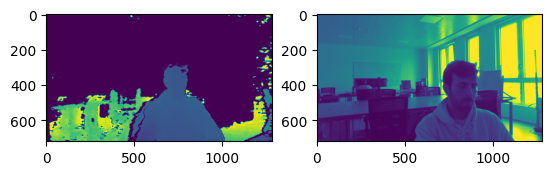

In [21]:
import math
import itertools

rgbd_image, intr = acquire(False)
plt.subplot(1,2,1)
plt.imshow(rgbd_image.depth)
plt.subplot(1,2,2)
plt.imshow(rgbd_image.color)

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr.width, intr.height, intr.fx, intr.fy, intr.ppx, intr.ppy
))
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 1]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object
pcd = pcd.crop(bounding_box)
o3d.visualization.draw_geometries([pcd])

Anche avendo la stessa risoluzione (1280x720) nelle 2 camere IR e quella RGB, non troviamo corrispondenza pixel-by-pixel tra le due immagini.
Questo è dovuto al posizionamento fisico dei sensori (displacement tra rgb e IR) e ai differenti Field Of View dei sensori.
RealSense mette a disposizione un metodo che permette di allineare le due immagini (traslazione e scala).

In [ ]:
import math
import itertools

rgbd_image, intr = acquire(True)
plt.subplot(1,2,1)
plt.imshow(rgbd_image.depth)
plt.subplot(1,2,2)
plt.imshow(rgbd_image.color)

camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr.width, intr.height, intr.fx, intr.fy, intr.ppx, intr.ppy
))
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 1]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object
pcd = pcd.crop(bounding_box)
o3d.visualization.draw_geometries([pcd])

# Introduzione della seconda camera

### Perché una seconda camera?
Lo scopo è quello di raccogliere dettagli di una faccia 2.5D coprendo idealmente l'area compresa tra l'orecchio destro e sinistro.

## Setup di acquisizione

![](setup.jpg)

## I parametri
* Distanza delle due camere
* Rotazione delle due camere

Per raccogliere più dettagli possibili del volto dobbiamo far si che il volto da acquisire si trovi nell'intersezione dei due Field Of Views delle camere.
Data una configurazione di distanza e rotazione, dobbiamo impostare una distanza del soggetto tale per cui esso ricada nell'intersezione dei due FOV.

![](ParametriSetup.png)

Vogliamo far si che la distanza del soggetto dalle camere sia minima per ottenere una risoluzione spaziale massima -> Soggetto lontano pochi pixel rappresentano naso, soggetto vicino molti più pixel rappresentano la stessa porzione di soggetto.
Vorremmo camere laterali per l'acquisizione migliore dell'orecchio andando a perdere la parte frontale (3 camera o trade-off).



# Acquisizione delle point-cloud

Ogni ricostruirà una point cloud, queste dovranno poi essere fuse. 

* Camere sovrapposte: le point cloud corrisponderanno "perfettamente"
* Camere traslate
* Camere traslate e ruotate

# Solo traslazione

In [ ]:
camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr.width, intr.height, intr.fx, intr.fy, intr.ppx, intr.ppy
))
camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr.width, intr.height, intr.fx, intr.fy, intr.ppx, intr.ppy
))

depth_raw_left = o3d.io.read_image("d_translate_l.png")
color_raw_left = o3d.io.read_image("c_translate_l.jpg")

rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)

depth_raw_right = o3d.io.read_image("d_translate_r.png")
color_raw_right = o3d.io.read_image("c_translate_r.jpg")

rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)

pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 1]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

p1_load = np.asarray(pcd_left.points)
p1_color = np.asarray(pcd_left.colors)
p2_load = np.asarray(pcd_right.points)
p2_color = np.asarray(pcd_right.colors)

p3_load = np.concatenate((p1_load, p2_load), axis=0)
p3_color = np.concatenate((p1_color, p2_color), axis=0)

new_pcd = o3d.geometry.PointCloud()
new_pcd.points = o3d.utility.Vector3dVector(p3_load)
new_pcd.colors = o3d.utility.Vector3dVector(p3_color)

o3d.visualization.draw_geometries([new_pcd])

# Traslazione e rotazione

In [ ]:
camera_intrinsic_left = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr.width, intr.height, intr.fx, intr.fy, intr.ppx, intr.ppy
))
camera_intrinsic_right = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsic(
    intr.width, intr.height, intr.fx, intr.fy, intr.ppx, intr.ppy
))

depth_raw_left = o3d.io.read_image("d_translate_l.png")
color_raw_left = o3d.io.read_image("c_translate_l.jpg")

rgbd_image_left = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_left, depth_raw_left)

depth_raw_right = o3d.io.read_image("d_translate_r.png")
color_raw_right = o3d.io.read_image("c_translate_r.jpg")

rgbd_image_right = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw_right, depth_raw_right)

pcd_left = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_left, camera_intrinsic_left)
pcd_right = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image_right, camera_intrinsic_right)

bounds = [[-math.inf, math.inf], [-math.inf, math.inf], [0.1, 1]]  # set the bounds
bounding_box_points = list(itertools.product(*bounds))  # create limit points
bounding_box = o3d.geometry.AxisAlignedBoundingBox.create_from_points(o3d.utility.Vector3dVector(bounding_box_points))  # create bounding box object

# Crop the point cloud using the bounding box:
pcd_left = pcd_left.crop(bounding_box)
pcd_right = pcd_right.crop(bounding_box)

